In [1]:
# https://github.com/patrickloeber/pytorchTutorial/blob/master/15_transfer_learning.py

import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

In [2]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

# https://download.pytorch.org/tutorial/hymenoptera_data.zip
data_dir = "data/hymenoptera_data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ["train", "val"]}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
               for x in ["train", "val"]}

dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['ants', 'bees']


In [3]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

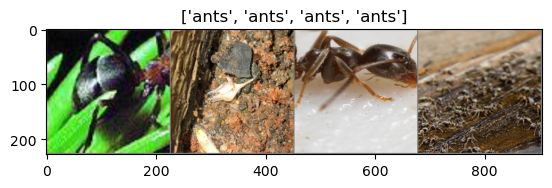

In [4]:
# get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f"epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)
        
        # each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train() # set model to training mode
            else:
                model.eval() # set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == "train":
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item()* inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == "train":
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f"{phase} loss: {epoch_loss:.4f} acc: {epoch_acc:.4f}")
            
            # deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
        time_elapsed = time.time() - since
        print(f"training complete in {time_elapsed // 60:.0f}, {time_elapsed % 60:.0f}s")
        print(f"best val acc: {best_acc:.4f}")
        
        # load best model weights
        model.load_state_dict(best_model_wts)
        return model

In [6]:
# finetuning the convnet
# load a pretrained model and reset final fully connected layer

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# here the size of each output sample is set to 2
# alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names))
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
# observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

C:\Users\Hello\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Hello\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# ConvNet as fixed feature extractor
# here, we need to freeze all the networks except the final layer
# we ned to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2) 

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# observe that only parameters of final layer are being optimized as opposed to before
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# decay LR by a factor of 1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

epoch 0/24
----------
train loss: 0.7599 acc: 0.6557
val loss: 0.2307 acc: 0.9281

training complete in 0, 33s
best val acc: 0.9281
